In [21]:
# import the library# impor 
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

sns.set_style('whitegrid')

### Loading the data 

In [44]:
df_books = pd.read_csv('books.csv')[['book_id', 'original_title']]
df_rat = pd.read_csv('ratings.csv')
df = pd.merge(df_books, df_rat)[['original_title', 'user_id', 'rating']]
df = df.dropna()
df.head()

,original_title,user_id,rating
0,The Hunger Games,2886,5
1,The Hunger Games,6158,5
2,The Hunger Games,3991,4
3,The Hunger Games,5281,5
4,The Hunger Games,5721,5


### The top rated books

In [15]:
df_rating_stats_by_book = df[['original_title', 'rating']].groupby(['original_title']).agg(['mean', 'count']).sort_values([('rating', 'mean')], ascending=False)
df_rating_stats_by_book.head()

rating      
                                                        mean count
original_title                                                    
The Complete Calvin and Hobbes                      4.829876   482
Attack of the Deranged Mutant Killer Monster Sn...  4.768707   147
The Indispensable Calvin and Hobbes: A Calvin a...  4.766355   214
The Revenge of the Baby-Sat: A Calvin and Hobbe...  4.761364   176
There's Treasure Everywhere: A Calvin and Hobbe...  4.760456   263

In [ ]:
df_user_rating = df[['original_title', 'rating']]
df_user_rating_freq = df_user_rating.groupby(['original_title', 'rating'])['original_title'].agg(['count'])
df_user_rating_freq.head(10)

### Distribution of ratings 

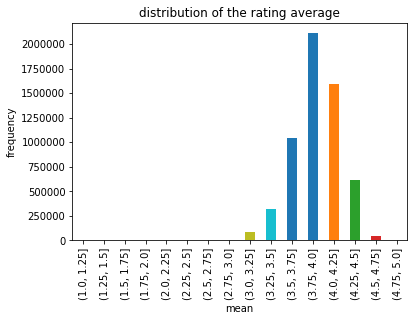

In [17]:
df_rating_stats_by_book['rating'].head()
df_rating_stats_by_book['rating'].groupby(pd.cut(df_rating_stats_by_book['rating']['mean'], bins=np.linspace(1,5,17))).sum()['count'].plot.bar()
plt.ylabel('frequency')
plt.title('distribution of the rating average')
plt.show()

### Clustering book title based on their ratings: 

In [51]:
df = df_user_rating_freq.pivot_table(index='original_title', columns='rating', values='count', fill_value=0)
df.head()

rating,1,2,3,4,5
original_title,,,,,
,5,54,257,302,346
A Monster Calls,5,21,105,305,506
Animal Farm & 1984,11,50,259,512,572
"Burned (Burned, #1)",6,19,63,100,142
Call the midwife : a true story of the East End in the 1950s,1,4,69,233,140


In [52]:
# remove column
X_columns = list(df.columns)
if 'IncomeErr' in X_columns:
    X_columns.remove('IncomeErr')
if 'IncomePerCapErr' in X_columns:
    X_columns.remove('IncomePerCapErr')
df = df[X_columns]

# normalize the columns
df_norm = df.copy()
for col in X_columns:
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))

print(df.shape)
df_norm.head()

(9274, 5)


C:\Users\Ayham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


rating,1,2,3,4,5
original_title,,,,,
,-0.156154,0.177514,0.406312,0.171915,0.265649
A Monster Calls,-0.156154,-0.183243,-0.140954,0.178585,0.572430
Animal Farm & 1984,-0.039670,0.133786,0.413513,0.638812,0.698977
"Burned (Burned, #1)",-0.136740,-0.205107,-0.292172,-0.277196,-0.125496
Call the midwife : a true story of the East End in the 1950s,-0.233810,-0.369087,-0.270569,0.018506,-0.129331


### Feature Engineering 

In [71]:
k = 5
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

{0, 1, 2, 3, 4}
Counter({0: 7401, 4: 1647, 1: 162, 3: 49, 2: 15})


###  Model Training

##### As you can see most of the ratining as metioned before it is distr

[(' Burned (Burned, #1)', 1), (' Call the midwife : a true story of the East End in the 1950s', 1), (' Carry On, Warrior: Thoughts on Life Unarmed ', 1), (' Carter Beats the Devil', 1), (' Crown of Shadows', 1)]
[('A Christmas Carol', 1), ('A Clash of Kings', 1), ('A Clockwork Orange', 1), ('A Dance with Dragons', 1), ('A Feast for Crows', 1)]
[('Angels & Demons ', 1), ('Breaking Dawn', 1), ("Eat, pray, love: one woman's search for everything across Italy, India and Indonesia", 1), ('Eclipse', 1), ('Fifty Shades of Grey', 1)]
[(' The Fellowship of the Ring', 1), ('A Game of Thrones', 1), ('A Wrinkle in Time', 1), ('An Excellent conceited Tragedie of Romeo and Juliet', 1), ('Animal Farm: A Fairy Story', 1)]
[(' ', 1), (' A Monster Calls ', 1), (' Animal Farm & 1984', 1), (' The Tale of Despereaux', 1), ("'Salem's Lot The Illustrated Edition", 1)]
1


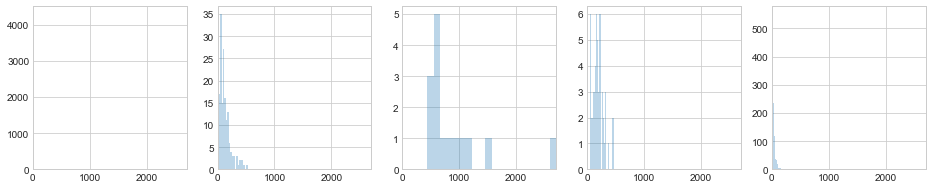

2


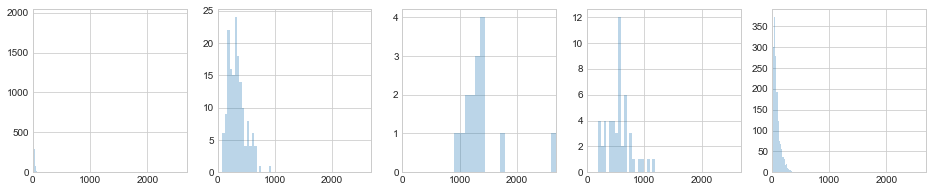

3


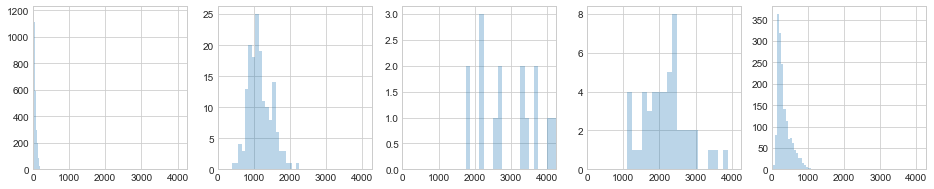

4


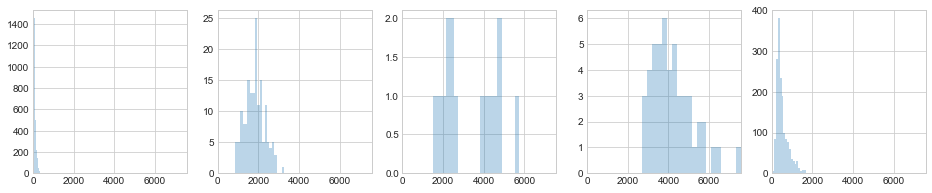

5


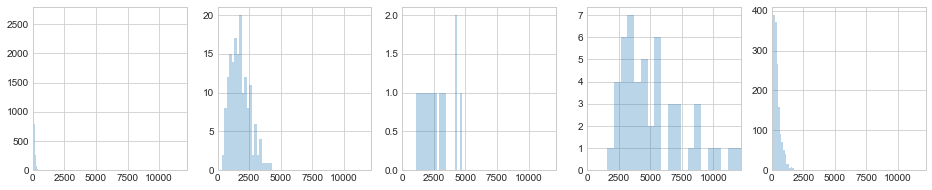

In [72]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(kmeans.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['original_title']).most_common(5))

n_clusters = len(set(kmeans.labels_))
for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
    plt.show()

In [73]:
# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4
rating,,,,,
1,4.22,134.44,891.73,194.63,27.33
2,14.15,338.23,1381.80,546.02,86.97
3,60.03,1171.33,2946.13,2183.04,334.95
4,94.39,1830.43,3318.93,4227.41,504.95
5,83.77,1781.51,2664.33,5187.39,437.86


1


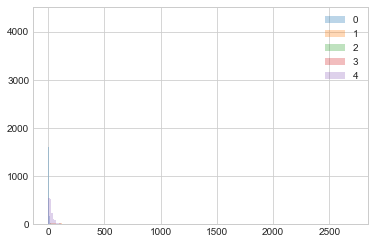

2


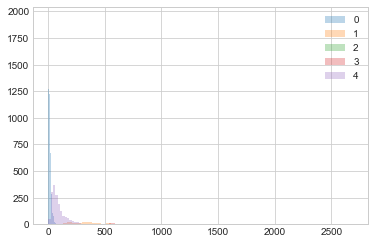

3


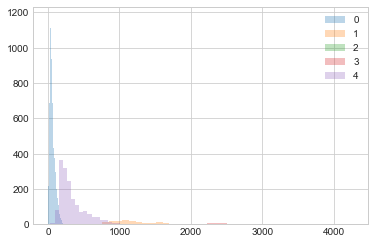

4


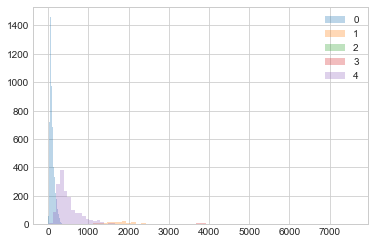

5


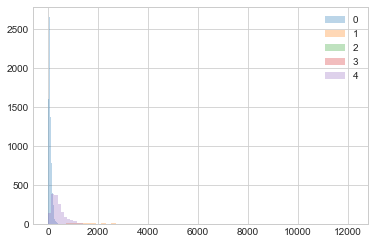

In [74]:
# Analyze the results
for col in X_columns:
    print(col)
    for cluster in set(kmeans.labels_):
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
    plt.legend()
    plt.show()

### Model Evaluation 

In [75]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(kmeans.labels_)):
    centroids.append(df_norm[df_norm['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 6.03333312666773
Intra Cluster distance 0.15798013529909852
Inertia 9914.900560695223


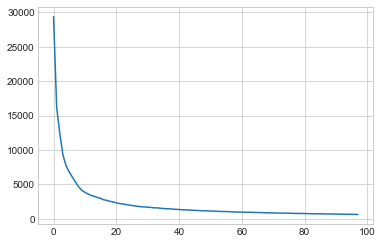

In [58]:
inertia = []
for k in range(2, 100):
    kmeans = KMeans(n_clusters=k).fit(df_norm.values)
    inertia.append(kmeans.inertia_)
plt.plot(inertia)
plt.show()